In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figure').absolute()

df_meta_path = data_dir / 'OCT mouse' / 'Whole' / 'metadata' /  'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

In [5]:
import palettable

ppi_colors = palettable.colorbrewer.qualitative.Set1_5.mpl_colors

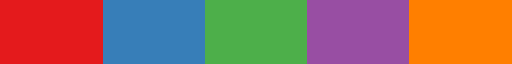

In [6]:
from matplotlib import colors 

colors.ListedColormap(ppi_colors)

# Viz PPI network

In [7]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    try:
        contour_cell = contours[key]['Cell'][int(cell)]
    except:
        contour_cell = None
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax
    
def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    try:
        contour = max(contour_cell, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    except:pass
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:pass

In [8]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy

# Get encoder 
PPI_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
# colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']
colors = ppi_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['CylinE & CDK2', 'Mcl-1 & BAK', 'P-ERK & c-MYC', 'TEAD1 & YAP1',
       'p-AKT & mTOR'], dtype=object)]


In [9]:
df.head()

,Cyto,x,y,PPI,Nuclei,Condition,FOV,Labels
0,14586,5545,866,TEAD1 & YAP1,14586,1M,FW1,"[0, 0, 0, 1, 0]"
1,14586,5545,866,TEAD1 & YAP1,14586,1M,FW1,"[0, 0, 0, 1, 0]"
2,14586,5545,866,TEAD1 & YAP1,14586,1M,FW1,"[0, 0, 0, 1, 0]"
3,14586,5545,866,TEAD1 & YAP1,14586,1M,FW1,"[0, 0, 0, 1, 0]"
4,1252,521,13171,TEAD1 & YAP1,0,1M,FW1,"[0, 0, 0, 1, 0]"


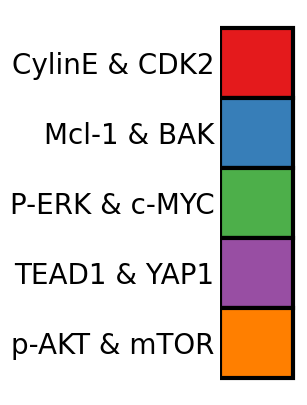

In [10]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [11]:
import PLA

graph_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [12]:
# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'nuclei', 'labels', 'pos'}


# Plot Whole FOV PPI network

In [23]:
group = cell_data.df.groupby(['Condition', 'FOV'])

In [24]:
fig_path = fig_dir / 'PPI' / 'OCT mouse' / 'Whole' / 'FOV'
fig_path.mkdir(parents=True, exist_ok=True)

In [29]:
# Loop through Condition FOV
for name, df_group in group:
    # Get imgs shape 
    path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    with h5py.File(path, "r") as f:
        img_shape = f['imgs'].shape[1:]
        
    file_name = '_'.join(name)
    file_path = fig_path / f'{file_name}.png'
    if file_path.exists():
        print(file_path)
        continue

    img_fov = np.zeros(img_shape)
    
    fig, ax = plt.subplots(figsize=(30,20))
    ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    ax.set_facecolor('k')

    # Get Individual cell
    for row in tqdm(df_group.itertuples(), total=len(df_group)):
        key = '_'.join(row[1:3])
        cell = row[3]
        
        # Get contours
        _, contour_nuclei = get_contours(cell_data.contours, key, cell)
        
        # Plot contours
        plot_contour(None, contour_nuclei, ax, linewidth=0.5)
        
        # Get graph
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
        # Plot network
        plot_network(network,  node_colors, ax, node_size=0.3, linewidths=0, edgecolors='w', width=0.15, edge_color='w')
    
    file_name = '_'.join(name)
    fig.savefig(fig_path / f'{file_name}.png', dpi=1500, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()


  0%|          | 0/15583 [00:00<?, ?it/s]

  0%|          | 0/13909 [00:00<?, ?it/s]

  0%|          | 0/8435 [00:00<?, ?it/s]

  0%|          | 0/7770 [00:00<?, ?it/s]

  0%|          | 0/3932 [00:00<?, ?it/s]